In [1]:
import numpy as np
import MDAnalysis as mda
import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

In [3]:
# This would be a typical use case
U = mda.Universe('data/6lyz.pdb')
traj = Trajectory(U, selection='protein')
env = Environment()
mea = Measurement(q = np.linspace(0.03, 0.8, num=200))
# XS = traj_calc(traj, env, mea)

# Do something with XS. E.g. fitting etc.


The protein has 1001 atoms


In [4]:
sel = U.select_atoms('protein')

In [5]:
sel.positions

array([[  3.287,  10.092,  10.329],
       [  2.445,  10.457,   9.182],
       [  2.5  ,  11.978,   9.038],
       ...,
       [-12.954,  22.586,   8.097],
       [-12.974,  20.117,   7.959],
       [-17.84 ,  19.891,   8.551]], dtype=float32)

In [4]:
traj.SASA_calc_traj(env)

print(traj.Frames[0].SASA)
np.shape(traj.Frames[0].SASA)

[0.025 0.145 0.    ... 0.03  0.    0.2  ]


(1001,)

In [16]:
frame.mol.n_atoms

1001

In [6]:
frame = traj.Frames[0]

frame.SASA_calc(env)

FF_q = FF_calc(frame, env, mea)

# an i by j matrix of distances between all atoms
d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

XS = np.zeros(np.shape(mea.q))
for i in np.arange(frame.mol.n_atoms):
    for j in np.arange(frame.mol.n_atoms-1)+1:
        qd = mea.q * d_ij[i,j]
        XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
    XS += FF_q[i] ** 2

<IPython.core.display.Javascript object>


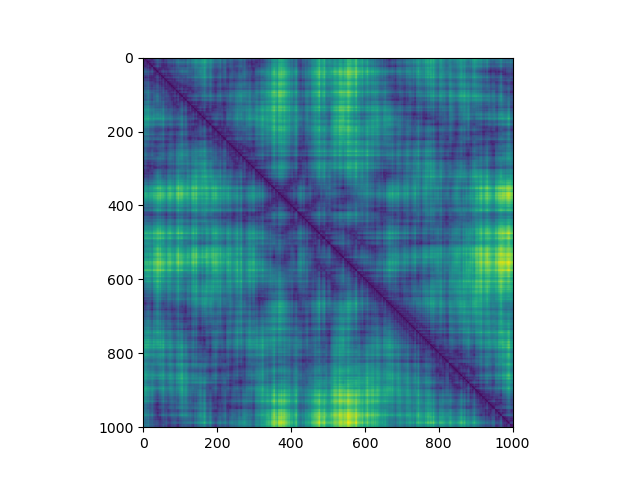

In [32]:
plt.imshow(d_ij)
plt.show()

In [4]:
def frame_XS_calc(frame, env, mea, ignoreSASA=False): # Calculate the X-ray scattering of a frame
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)

    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

    # Calculate scattering signal XS
    XS = np.zeros(np.shape(mea.q))
    for i in np.arange(frame.mol.n_atoms):
        for j in np.arange(frame.mol.n_atoms-1)+1:
            qd = mea.q * d_ij[i,j]
            XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
        XS += FF_q[i] ** 2

    return XS

In [7]:
XS = frame_XS_calc(traj.Frames[0], env, mea)

<IPython.core.display.Javascript object>


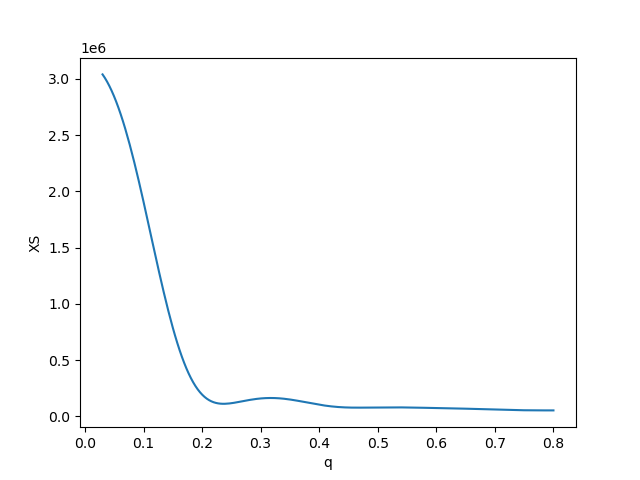

In [10]:
plt.plot(mea.q, XS)
plt.ylabel('XS')
plt.xlabel('q')
plt.show()

<IPython.core.display.Javascript object>


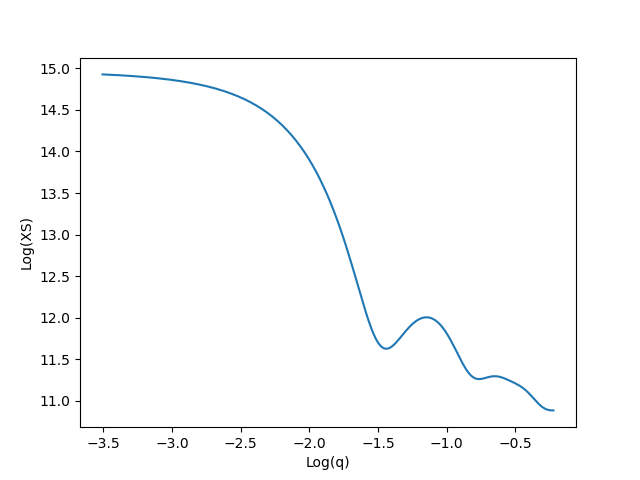

In [11]:
plt.plot(np.log(mea.q),np.log(XS))
plt.ylabel('Log(XS)')
plt.xlabel('Log(q)')
plt.show()